In [1]:
%matplotlib inline
import tensorflow as tf 

import cv2
import pandas as pd
from glob import glob
import pickle
import numpy as np

import os
import sys
import random
import math
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path = 'gdrive/MyDrive/Colab Notebooks/Crysteo'

In [4]:
import sys
sys.path.insert(0,path) #Permette de importer les fichier Python dans au fichier

In [5]:
import pandas as pd
import xml.etree.ElementTree as et

def parse_XML(xml_file): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """

    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        df_cols =  []
        if node.tag == "object":
          for child in node:
            if child.tag == "bndbox":
              xmin, ymin, xmax, ymax = [i.text for i in child]
              res.append((xmin, ymin, xmax, ymax))
              df_cols.append(child.tag)
              continue
            res.append(child.text)
            df_cols.append(child.tag)
          rows.append({df_cols[i]: res[i] for i, _ in enumerate(df_cols)})
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

In [6]:
folder = path + '/Fine/'

images_list = sorted(glob(folder + "*.png"))
anchor_list = sorted(glob(folder + "*.xml"))

In [7]:
print(len(images_list)," ",len(anchor_list))

431   432


In [8]:
image_test = images_list[1]
anchor_test = anchor_list[1]
img = cv2.cvtColor(cv2.imread(image_test),cv2.COLOR_BGR2RGB)

In [9]:
anchor = parse_XML(anchor_test)
anchor.head

<bound method NDFrame.head of          name         pose truncated difficult                bndbox
0  green_buoy  Unspecified         0         0     (15, 61, 52, 117)
1  green_buoy  Unspecified         0         0    (170, 45, 186, 72)
2  green_buoy  Unspecified         0         0    (184, 27, 195, 49)
3  green_buoy  Unspecified         0         0    (259, 32, 270, 53)
4  green_buoy  Unspecified         0         0  (251, 100, 303, 174)
5  green_buoy  Unspecified         1         0  (238, 239, 304, 304)
6    red_buoy  Unspecified         0         0   (74, 113, 128, 211)
7    red_buoy  Unspecified         0         0   (174, 59, 201, 103)
8    red_buoy  Unspecified         0         0    (162, 33, 176, 58)
9    red_buoy  Unspecified         0         0    (248, 35, 263, 56)>

In [10]:
def visual(image,anchor):
  for t in anchor.iterrows():
    x1,y1,x2,y2 = t[1]['bndbox']
    if t[1]['name'] == "green_buoy":
      cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3)
    else:
      cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),3)
  return image

In [11]:
NUM_CLASSES = 1 + 1 + 1 #backgournd + vert + rouge

In [12]:
from tqdm import tqdm

def binarylab(image,box):
  x = np.zeros([image.shape[0],image.shape[1],NUM_CLASSES])  
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      x[j,i,0] = 1

  for t in box.iterrows():
    x1,y1,x2,y2 = t[1]['bndbox']
    if t[1]['name'] == "green_buoy":
        for i in range(int(x1),int(x2)):
          for j in range(int(y1),int(y2)):
            x[j,i,1] = 1
            x[j,i,0] = 0
    if t[1]['name'] == "red_buoy":
        for i in range(int(x1),int(x2)):
          for j in range(int(y1),int(y2)):
            x[j,i,2] = 1
            x[j,i,0] = 0 
  return x                      

def make_dataset(image_list, mask_list):
  images = []
  masks = []
  for img, mask in tqdm(zip(image_list, mask_list),total=len(image_list)):
    images.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))   
    masks.append(binarylab(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB),parse_XML(mask)))
  images = np.array(images)
  masks = np.array(masks)
  return images, masks

100%|██████████| 431/431 [00:12<00:00, 34.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd4bd360d0>,
 (-0.5, 303.5, 303.5, -0.5))

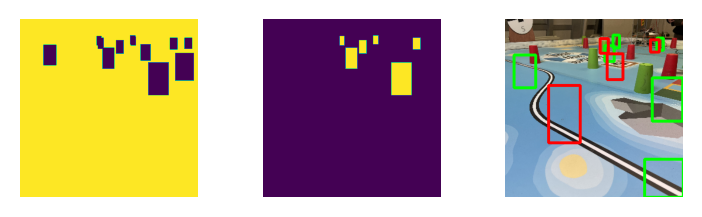

In [25]:
from matplotlib.gridspec import GridSpec
from random import randint, sample

X, Y = make_dataset(images_list, anchor_list)

 
gs = GridSpec(3,4)
plt.figure(dpi=200)

plt.subplot(gs[0]), plt.imshow(Y[0][:,:,0]), plt.axis('off')  
plt.subplot(gs[1]), plt.imshow(Y[0][:,:,1]), plt.axis('off')
plt.subplot(gs[2]), plt.imshow(Y[0][:,:,2]), plt.axis('off')   
plt.subplot(gs[2]),  plt.imshow(visual(X[0],anchor)), plt.axis('off')   

In [14]:
!pip install keras-unet

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [16]:
from keras_unet.models import custom_unet

model = custom_unet(input_shape = img.shape,num_classes=NUM_CLASSES)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [17]:
#model.summary()

In [18]:
#sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0)
#opt = tf.keras.optimizers.Adam(learning_rate=0.005)

class MeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,y_true=None,y_pred=None,num_classes=NUM_CLASSES,name='mIoU',dtype=None):
    super(MeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.math.argmax(y_true, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc',MeanIoU()])

In [19]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

filepath = path + "/tmp/saved-model.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_mIoU', verbose=1, save_best_only=True, mode='max')

In [20]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs=200,
                    callbacks=[checkpoint])

Epoch 1/200
9/9 [==============================] - 21s 769ms/step - loss: 0.7476 - acc: 0.3909 - mIoU: 0.1691 - val_loss: 5.1301 - val_acc: 0.4712 - val_mIoU: 0.1858

Epoch 00001: val_mIoU improved from -inf to 0.18580, saving model to gdrive/MyDrive/Colab Notebooks/Crysteotmp/saved-model.hdf5
Epoch 2/200
9/9 [==============================] - 5s 519ms/step - loss: 0.6832 - acc: 0.5632 - mIoU: 0.2576 - val_loss: 4.8003 - val_acc: 0.5441 - val_mIoU: 0.2012

Epoch 00002: val_mIoU improved from 0.18580 to 0.20122, saving model to gdrive/MyDrive/Colab Notebooks/Crysteotmp/saved-model.hdf5
Epoch 3/200
9/9 [==============================] - 5s 521ms/step - loss: 0.6582 - acc: 0.6837 - mIoU: 0.3254 - val_loss: 2.4003 - val_acc: 0.6030 - val_mIoU: 0.2279

Epoch 00003: val_mIoU improved from 0.20122 to 0.22787, saving model to gdrive/MyDrive/Colab Notebooks/Crysteotmp/saved-model.hdf5
Epoch 4/200
9/9 [==============================] - 5s 526ms/step - loss: 0.6364 - acc: 0.7290 - mIoU: 0.3615 - 

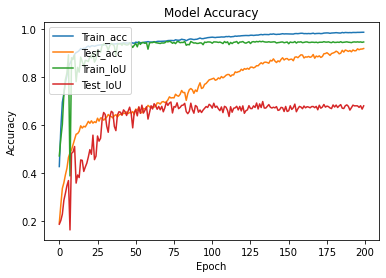

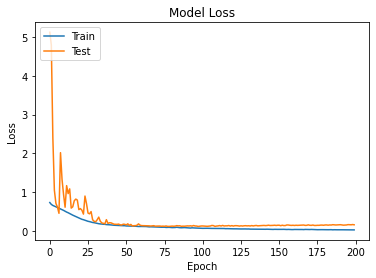

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['mIoU'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_mIoU'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_acc', 'Test_acc','Train_IoU', 'Test_IoU'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
model = load_model(filepath) #load the wieght 

(304, 304, 3)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd4a8a7390>,
 (-0.5, 303.5, 303.5, -0.5))

<Figure size 1200x800 with 0 Axes>

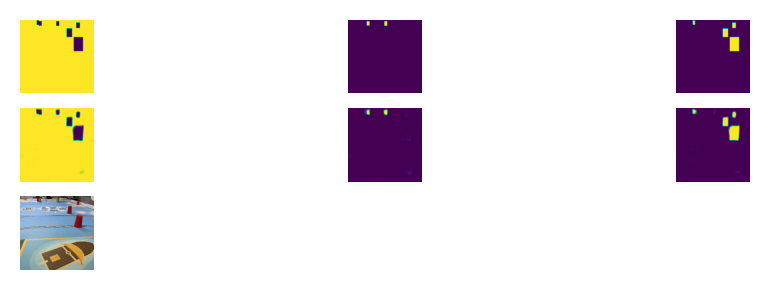

In [23]:
randsample = sample(range(0,len(X_test)-1), 4)
gs = GridSpec(3,5)
plt.figure(dpi=200)


for i in range(4):
    X = X_test[randsample[i]]
    y = y_test[randsample[i]]
    y_pred = model.predict(np.array([X]))[0]
print(y_pred.shape)


gs = GridSpec(7,3)
plt.figure(dpi=200)

plt.subplot(gs[0]), plt.imshow(y[:,:,0]), plt.axis('off')  
plt.subplot(gs[1]), plt.imshow(y[:,:,1]), plt.axis('off')
plt.subplot(gs[2]), plt.imshow(y[:,:,2]), plt.axis('off')   

plt.subplot(gs[3]), plt.imshow(y_pred[:,:,0]), plt.axis('off')  
plt.subplot(gs[4]), plt.imshow(y_pred[:,:,1]), plt.axis('off')
plt.subplot(gs[5]), plt.imshow(y_pred[:,:,2]), plt.axis('off')   

plt.subplot(gs[6]), plt.imshow(X), plt.axis('off')   

18
117
139
32


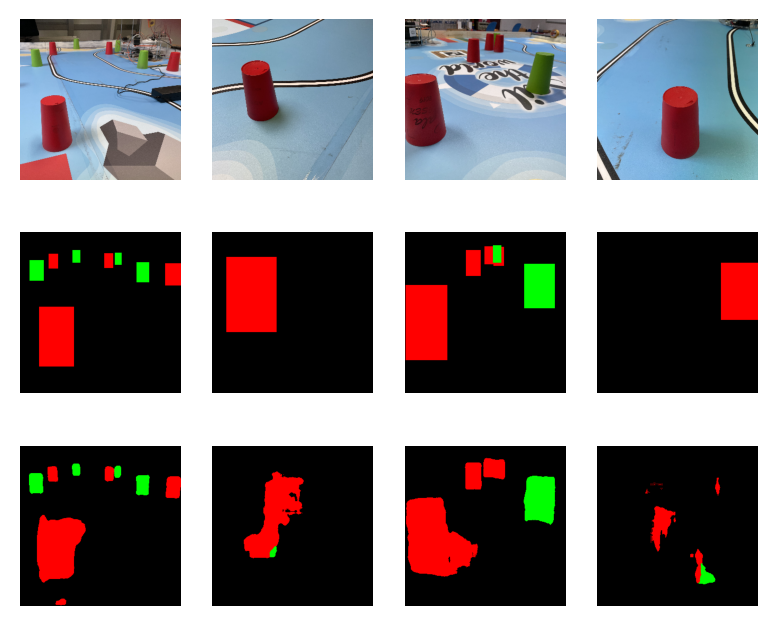

In [24]:
    def visualize(temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()

        label_coulors = np.array([[0,0,0],[0,255,0],[255,0,0]])

        #for l in [0, 3, 4, 8]:
        for l in range(len([[0,0,0],[255,0,0],[0,255,0]])):
            r[temp==l]=label_coulors[l,0]
            g[temp==l]=label_coulors[l,1]
            b[temp==l]=label_coulors[l,2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:,:,0] = (r/255.0)
        rgb[:,:,1] = (g/255.0)
        rgb[:,:,2] = (b/255.0)
        return rgb

randsample = sample(range(0,len(X_test)-1), 4)
gs = GridSpec(3,5)
plt.figure(dpi=200)


for i in range(4):
  print(randsample[i])
  X = X_test[randsample[i]]
  y = y_test[randsample[i]]
  y_pred = model.predict(np.array([X]))[0]

  plt.subplot(gs[i]), plt.imshow(X), plt.axis('off') 
  plt.subplot(gs[5+i]), plt.imshow(visualize(np.argmax(y, axis=2))), plt.axis('off')  
  plt.subplot(gs[10+i]), plt.imshow(visualize(np.argmax(y_pred, axis=2))), plt.axis('off')

In [98]:
def seepredict(image):
  X = image
  y_pred = model.predict(np.array([X]))[0]

  img = X.copy()

  rgb = visualize(np.argmax(y_pred, axis=2))
  # Scale and convert data type
  image_8bit = np.uint8(rgb * 255)

  gray = cv2.cvtColor(image_8bit, cv2.COLOR_BGR2GRAY)

  _, binarized = cv2.threshold(gray, 0, 128, cv2.THRESH_BINARY)#only green

  contours, hierarchy = cv2.findContours(binarized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if w > 10 and h > 10:
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)

  _, binarized = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)#only red

  contours, hierarchy = cv2.findContours(binarized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if w > 10 and h > 10:
      cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)

  return img

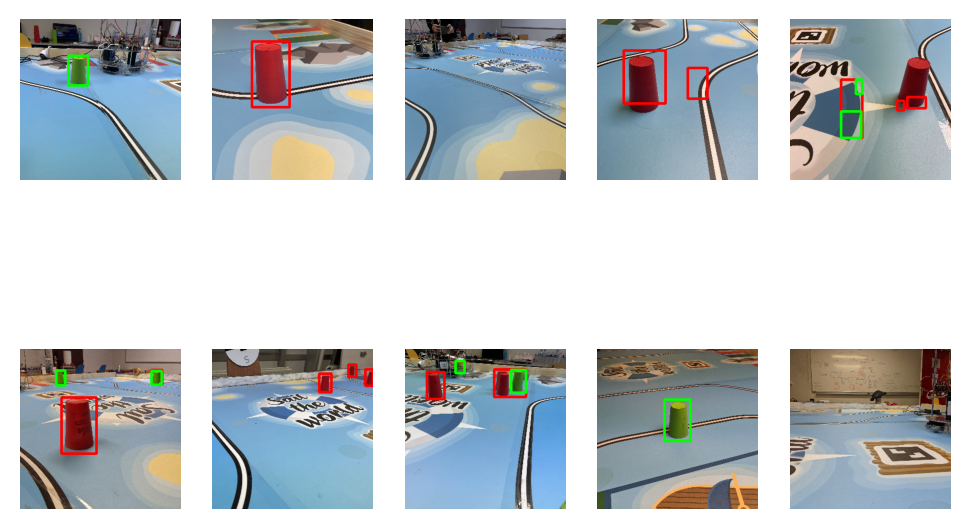

In [100]:
randsample = sample(range(0,len(X_test)-1), 10)
gs = GridSpec(2,5)
plt.figure(dpi=200)

for i in range(10):
  X = X_test[randsample[i]]
  img = seepredict(X)
  plt.subplot(gs[i]), plt.imshow(img), plt.axis('off') 